# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that we've discussed some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modelling pipeline.  

With this pipeline, yoiu will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modelling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. We've discussed the bias variance tradeoff, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modelling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

## Loading the Data

In [ ]:
#Your code here; load and preview the dataset
import pandas as pd
df = pd.read_csv('loan_final.csv')
df.head().T
df.dropna(inplace=True)

## Defining the Problem

Set up the problem by defining X and Y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Be sure to use dummy variables for categorical variables and to normalize numerical quanitities. Be sure to also remove any rows with null data.  

For Y, we are looking to build a model to predict the total payment received for a loan.

In [46]:
# Your code here; appropriately define X and Y using dummy variables and normalization for preprocessing.
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

X = df[['loan_amnt', 'home_ownership', 'funded_amnt_inv', 'verification_status',
       'emp_length', 'installment', 'annual_inc']]
ohe = OneHotEncoder()
ss = StandardScaler()

enc_ho = X['home_ownership']
enc_vs = X['verification_status']
enc_emp = X['emp_length']
enc_ho = enc_ho.values.reshape(-1,1)
enc_vs = enc_vs.values.reshape(-1,1)
enc_emp = enc_emp.values.reshape(-1, 1)
ohe.fit(enc_ho)
enc_ho = pd.DataFrame(ohe.transform(enc_ho).toarray(), columns=ohe.get_feature_names(['home_ownership']))
ohe.fit(enc_vs)
enc_vs = pd.DataFrame(ohe.transform(enc_vs).toarray(), columns=ohe.get_feature_names(['verification_status']))
ohe.fit(enc_emp)
enc_emp = pd.DataFrame(ohe.transform(enc_emp).toarray(), columns=ohe.get_feature_names(['emp_length']))

X_s = X.drop(['home_ownership', 'verification_status', 'emp_length'],axis=1)
X_s = pd.DataFrame(ss.fit_transform(X_s), columns=X_s.columns)

X = pd.concat([X_s, enc_ho, enc_vs], axis=1)

y = df['total_pymnt']



ValueError: Input contains NaN

## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modelling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [29]:
# Your code here; generate a hold out test set for final model evaluation. Use random seed 123.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=123)

## Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. Be sure your function returns performance metrics regarding the training and validation sets.

In [40]:
#Your code here; define a function to evaluate a model object using K folds cross validation.
from sklearn.model_selection import KFold

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette("Set2")
    kf = KFold(n_splits=10,shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    validation_scores = []
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        row = i//5
        column = i%5
        
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=32,
                        verbose=0)
        
        validation = model.evaluate(X_val, y_val)
        validation_scores.append(validation)
        ax = axes[row,col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, colors=colors[1])
        ax.set_title(f'Fold {i+1} Validation')
    plt.subplots_adjust(left=None, right=None, bottom=None, top=None, wspace=.5, hspace=None)
    plt.legend(bbox_to_anchor=(1, 1))
    
    validation_score = np.mean(validation_scores)
    print(f'Mean Validation Score: {validation_score}')
    print(f'STD of Validation Scores: {np.std(validation_scores)}')
    return validation_score

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model.   

In general, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. We set up a k-folds cross-validation for this task since the dataset is not overly large.  

Build an initial sequential model with 2 hidden relu layers. The first should have 7 hidden units, and the second 10 hidden units. Finally, add a third layer with a linear activation function to output our predictions for the total loan payment. 

In [41]:
#Your code here; define and compile an initial model as described
from keras import Sequential
from keras.layers import Dense

inputs = X_train.shape[1]
model = Sequential()
model.add(Dense(inputs, activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: x=       loan_amnt home_ownership  funded_amnt_inv verification_status  \
28927     6000.0           RENT       5950.00000     Source Verified   
18623     5000.0           RENT       4950.00000     Source Verified   
30212    25000.0           RENT      23457.05000            Verified   
33624    12000.0       MORTGAGE      12000.00000            Verified   
21095    24000.0       MORTGAGE      23950.00000            Verified   
23159    15000.0       MORTGAGE      13088.66441     Source Verified   
8944     10000.0           RENT      10000.00000        Not Verified   
16768    16225.0       MORTGAGE      16225.00000     Source Verified   
35123     6000.0       MORTGAGE       5975.00000            Verified   
8167      8000.0       MORTGAGE       8000.00000        Not Verified   
25406     5000.0           RENT       5000.00000        Not Verified   
36852    12000.0       MORTGAGE      11725.00000        Not Verified   
8315     35000.0       MORTGAGE      26575.00000            Verified   
8668     12000.0       MORTGAGE      12000.00000            Verified   
30184    25000.0           RENT      16231.68103            Verified   
2698      1000.0           RENT       1000.00000            Verified   
29258    24000.0       MORTGAGE      14950.64088            Verified   
37594    13000.0           RENT      12499.99959            Verified   
21144     4200.0            OWN       4175.00000        Not Verified   
9750      5000.0       MORTGAGE       5000.00000        Not Verified   
22168    13000.0       MORTGAGE      12475.00000     Source Verified   
29695    25000.0           RENT      15783.43465            Verified   
36299     6200.0           RENT       6150.00000            Verified   
30556    20400.0           RENT      20400.00000            Verified   
35471     6000.0       MORTGAGE       5950.00000            Verified   
23284    18000.0       MORTGAGE      17900.00000     Source Verified   
15021     1800.0           RENT       1800.00000        Not Verified   
28762     4800.0       MORTGAGE       4721.28235        Not Verified   
31592     6525.0           RENT       6500.00000        Not Verified   
11507    15000.0       MORTGAGE      14750.00000     Source Verified   
...          ...            ...              ...                 ...   
20355     5000.0            OWN       5000.00000        Not Verified   
16972    11000.0           RENT      11000.00000        Not Verified   
2338     12000.0           RENT      12000.00000        Not Verified   
29534    13200.0       MORTGAGE      12520.83374        Not Verified   
11894     5000.0           RENT       5000.00000            Verified   
28513     4500.0           RENT       4500.00000        Not Verified   
3252      6000.0           RENT       6000.00000            Verified   
8028     14400.0       MORTGAGE      13400.00000        Not Verified   
4195     21000.0           RENT      21000.00000            Verified   
23728    10000.0       MORTGAGE       9950.00000     Source Verified   
22461     9600.0       MORTGAGE       9525.00000        Not Verified   
6648     30100.0       MORTGAGE      30100.00000            Verified   
30255    24000.0           RENT      23673.01145            Verified   
42535     2525.0           RENT        225.00000        Not Verified   
6484     30000.0       MORTGAGE      29500.00000            Verified   
26626     8400.0       MORTGAGE       8300.00000            Verified   
7985     25000.0           RENT      19800.00000            Verified   
17476     2500.0            OWN       2500.00000     Source Verified   
31140     5000.0           RENT       5000.00000        Not Verified   
3325      1500.0            OWN       1500.00000        Not Verified   
17747    34000.0       MORTGAGE      33068.77746            Verified   
36249     2800.0            OWN       2775.00000        Not Verified   
33710     2500.0           RENT       2500.00000        Not Verified   
5664     15000.0       MORTGAGE      15000.00000            Verified   
23166     7000.0           RENT       6900.00000            Verified   
23766    15600.0       MORTGAGE      12771.01835     Source Verified   
7763     35000.0       MORTGAGE      27597.14945            Verified   
15377    10000.0       MORTGAGE      10000.00000            Verified   
17730     5425.0            OWN       5425.00000        Not Verified   
15725     3150.0           RENT       3150.00000            Verified   

      emp_length  installment  annual_inc  
28927    5 years       195.73     50000.0  
18623     1 year       160.47     65000.0  
30212     1 year       839.16    103250.0  
33624  10+ years       407.63     98004.0  
21095    6 years       588.75     90000.0  
23159  10+ years       460.01     74400.0  
8944     7 years       315.63     24000.0  
16768  10+ years       350.68     70800.0  
35123    2 years       204.83     62000.0  
8167         NaN       243.34     32000.0  
25406     1 year       155.56     38250.0  
36852    9 years       383.37     54000.0  
8315     6 years       680.49    125000.0  
8668   10+ years       404.27    150000.0  
30184   < 1 year       843.63    106000.0  
2698         NaN        34.50     11820.0  
29258    6 years       373.28     88100.0  
37594     1 year       441.00     51996.0  
21144    6 years        89.99     44500.0  
9750   10+ years       157.82     33000.0  
22168    5 years       400.87     37200.0  
29695    4 years       403.03     99996.0  
36299    7 years       211.27     45000.0  
30556    2 years       660.65     80004.0  
35471    2 years       189.67     52000.0  
23284    5 years       469.81     60000.0  
15021  10+ years        39.58     27000.0  
28762    2 years       146.88     52000.0  
31592     1 year       229.64     38000.0  
11507    9 years       391.51     75000.0  
...          ...          ...         ...  
20355  10+ years       155.05     60000.0  
16972    8 years       341.11     44000.0  
2338     4 years       373.33     32000.0  
29534  10+ years       334.70     62400.0  
11894    4 years       177.00    200000.0  
28513    7 years       155.38     90750.0  
3252     2 years       155.75     38400.0  
8028     4 years       313.02     70000.0  
4195      1 year       676.73     93000.0  
23728    2 years       377.47    108000.0  
22461  10+ years       289.54     75000.0  
6648     6 years       787.79    100000.0  
30255    2 years       818.50     60000.0  
42535   < 1 year        80.69    110000.0  
6484   10+ years       921.11     94000.0  
26626    8 years       261.34     39700.0  
7985     6 years       436.46    117000.0  
17476    2 years        80.24     20004.0  
31140    2 years       161.06     42000.0  
3325     6 years        48.86     34056.0  
17747    2 years       728.61    195000.0  
36249    4 years        96.28     54000.0  
33710    5 years        82.01     55000.0  
5664     9 years       488.60     85000.0  
23166    2 years       159.20     36188.0  
23766  10+ years       273.76     80000.0  
7763   10+ years       634.10     74004.0  
15377        NaN       308.73     61000.0  
17730    5 years       186.84    150000.0  
15725    9 years       103.12     15300.0  

[34455 rows x 7 columns]

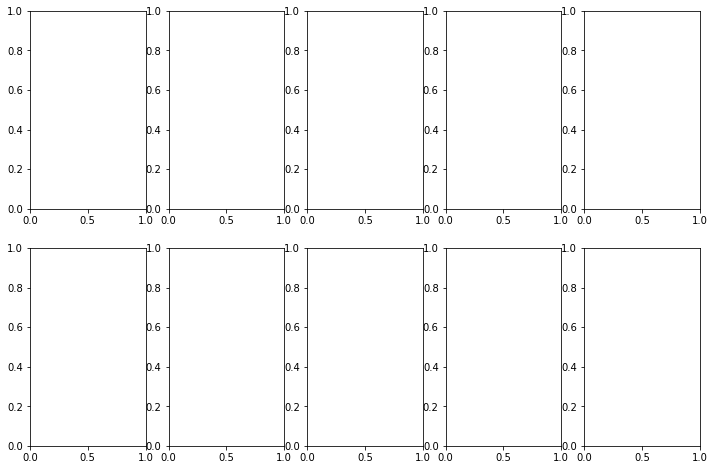

In [42]:
#Your code here; use your k-folds function to evaluate the baseline model.
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
now = datetime.datetime.now()
k_folds(X_train, y_train, model)
later = datetime.datetime.now()
elapsed = later-now
print('Time Elapsed:', elapsed)

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.  

For example, here are some timing notes on potential experiments run on a Macbook Pro 3.1 GHz Intel Core i5 with 16gb of RAM:

* Using our 10 fold cross validation methodology, a 5-layer neural network with 10 units per hidden layer and 100 epochs took approximately 15 minutes to train and validate  

* Using our 10 fold cross validation methodology, a 5-layer neural network with 25 units per hidden layer and 100 epochs took approximately 25 minutes to train and validate  

* Using our 10 fold cross validation methodology, a 5-layer neural network with 10 units per hidden layer and 250 epochs took approximately 45 minutes to train and validate


In [ ]:
#Your code here; try some methods to overfit your network

In [ ]:
#Your code here; try some methods to overfit your network

In [ ]:
#Your code here; try some methods to overfit your network

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

In [ ]:
#Your code here; try some regularization or other methods to tune your network

In [ ]:
#Your code here; try some regularization or other methods to tune your network

In [ ]:
#Your code here; try some regularization or other methods to tune your network

In [ ]:
#Your code here; try some regularization or other methods to tune your network

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your expirements above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modelling process)!

In [ ]:
#Your code here; final model training on entire training set followed by evaluation on hold-out data

## Additional Resources

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
https://www.springboard.com/blog/free-public-data-sets-data-science-project/

## Summary

In this lab, we investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. We began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, we implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, we'll begin to investigate other neural network architectures such as CNNs.